# Optimizacion con MAPL

$ G \leftarrow train(\{(HR_i, LR_i)\}_i) \  \forall i=1,2 ... n\_samples \hspace{2cm} con \ LR_i = downsampling(HR_i)$

$ M \leftarrow mapl(Y^{lr}.gtab) $


$ \min_{Y^{hr}, C} \{ ||GY^{hr} - Y^{lr}||^2 + ||Y^{hr}- MC||^2 + ||C||_{1} \}$



In [1]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
#import seaborn as sns
import utils.math_utils as mu
#import nibabel as nib
import mapmri.mapmri as mp
#from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)
import load.hcp_img_loader as hcp
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f

Populating the interactive namespace from numpy and matplotlib


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
def get_sample(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    img, gtab, idxs = loader_func(index, numbers, bval, bvalpos)
    lr, lr_affine = img_utils.downsampling(img, scale)
    data = img.get_data()
    return data[:,:,:, idxs], lr[:,:,:, idxs], gtab

def get_sample_maker(numbers, loader_func, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, loader_func, bval, bvalpos,  scale)

def mm(A, cast_int=True):
    if cast_int :
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    noised_hr, noised_lr, _ = sample_getter(0)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr, noised_lr, _ = sample_getter(i)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## Problem definition

$ \min_{Y^{hr}, C} \{ ||GY^{hr} - Y^{lr}||^2 + ||Y^{hr}- MC||^2 + ||C||_{1} \}$



## MapMri

In [3]:
def getM(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return  M

def get_mapl_params(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape
    M = getM(radial_order, mu, gtab, tau)
    return M, tau, mu
"""
def mapl_predict(gtab, C_or_Cvec, M, tau, Nx=None, Ny=None, Nz=None):
   
    is_cvxpy = isinstance(C_or_Cvec, cvx.Variable)
    print 'M.shape', M.shape, 'C.size', C_or_Cvec.size
    Nb, Nc = M.shape
    vhr, Nc = C_or_Cvec.shape if hasattr(C_or_Cvec, 'shape') else C_or_Cvec.size
    #vhr = Nx*Ny*Nz
    
    Cvec = C_or_Cvec
    if not is_cvxpy :
        Cvec = C.reshape((vhr, Nc), order='F')
         
    if is_cvxpy :
        E = (M * Cvec.T)
    else:
        E = np.dot(M, Cvec.T).T
        
    if not is_cvxpy :
        E = E.reshape((Nx, Ny, Nz, Nb), order='F')
    #else:
    #    E = E.reshape(-1, order='F')
        
    return E


def cvxpy_mapl(gtab, M, tau, vhr, Nc):
    # Image to fit
    cvxC = cvx.Variable(vhr, Nc)

    cvxMaplE = mapl_predict(gtab, cvxC, M, tau)

    return cvxMaplE, cvxC,
"""    
  
    
    

"\ndef mapl_predict(gtab, C_or_Cvec, M, tau, Nx=None, Ny=None, Nz=None):\n   \n    is_cvxpy = isinstance(C_or_Cvec, cvx.Variable)\n    print 'M.shape', M.shape, 'C.size', C_or_Cvec.size\n    Nb, Nc = M.shape\n    vhr, Nc = C_or_Cvec.shape if hasattr(C_or_Cvec, 'shape') else C_or_Cvec.size\n    #vhr = Nx*Ny*Nz\n    \n    Cvec = C_or_Cvec\n    if not is_cvxpy :\n        Cvec = C.reshape((vhr, Nc), order='F')\n         \n    if is_cvxpy :\n        E = (M * Cvec.T)\n    else:\n        E = np.dot(M, Cvec.T).T\n        \n    if not is_cvxpy :\n        E = E.reshape((Nx, Ny, Nz, Nb), order='F')\n    #else:\n    #    E = E.reshape(-1, order='F')\n        \n    return E\n\n\ndef cvxpy_mapl(gtab, M, tau, vhr, Nc):\n    # Image to fit\n    cvxC = cvx.Variable(vhr, Nc)\n\n    cvxMaplE = mapl_predict(gtab, cvxC, M, tau)\n\n    return cvxMaplE, cvxC,\n"

In [414]:
def define_problem_with_mapl(i_lr, i_hr_shape, downsampling_matrix, M, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    _, Nc = M.shape
    vhrb = Nx*Ny*Nz*bval
    vlr = Nx*Ny*Nz/(scale**3)
    vhr = Nx*Ny*Nz
      
    ### Hr volumes
    Yhr = cvx.Variable(vhrb, 1)
    #Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    Yhr.value = i_hr.reshape(-1, order='F')
    
    ### LR volumes
    Ylr = cvx.Constant(i_lr.reshape((vlr*bval, 1), order='F'))
    #Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    ### Downsampling matrix
    cvxG = cvx.Constant(downsampling_matrix)
    
    # Fidelity expression
    cvxFidelityExp = cvx.sum_squares(cvxG*Yhr - Ylr)
    
    
    ### MAPL params
    cvxM = cvx.Constant(M)
    cvxC = cvx.Variable(vhr, Nc)
    #        M:(Nb,Nc) cvxC:(vhr, Nc) cvxMaplE:(vhr, bval)
    cvxMaplE = (cvxM * cvxC.T).T
    # Hr image in row by b-val
    YhrMapl = cvx.reshape(Yhr, vhr, bval)
    # Mapl dual expression
    print cvxMaplE.size, YhrMapl.size
    cvxMaplDualExp = cvx.sum_squares(cvxMaplE-YhrMapl)
    
    
    ### Weights
    betha = cvx.Parameter(value=300000, sign='positive') #200, 300000
    ## Sparcity weight (antes 1500, 150, 75, 105)
    alpha = cvx.Parameter(value=200000, sign='positive')#150, 87
    ## Fidelity weight
    gamma = cvx.Parameter(value=1, sign='positive')#62
    
    norm1 = cvx.norm1(cvxC)
    # Form objective.
    #obj = cvx.Minimize(gamma*cvxFidelityExp + betha*cvxMaplDualExp + alpha*norm1)
    obj = cvx.Minimize(gamma*cvxFidelityExp)
    
    # Constraints
    constraints = []
    constraints.append(Yhr >= 0)
    constraints.append(cvxMaplE >= 0)
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, Yhr, Ylr, cvxC, cvxG, cvxFidelityExp, cvxMaplDualExp, norm1 


In [392]:
def solveMin(i_lr, i_hr_shape, downsampling_matrix, M, scale=2, max_iters=1500, verbose=False):
    Nx, Ny, Nz, Nb = i_hr_shape
    Nb, Nc = M.shape
    prob, Yhr, Ylr, cvxC, G, cvxFidelityExp, cvxMaplDualExp, norm1 = define_problem_with_mapl(
                                i_lr, 
                                i_hr_shape, 
                                downsampling_matrix, 
                                M, 
                                scale)
     
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=5.0e-03, verbose=verbose )  # Returns the optimal value.
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    # Change dimension of result representation
    C, A = None, None
    if Yhr.value is None :
        #Yhr.value = np.ones(i_hr_shape)
        print 'FRECONSTRUCTION FAIL :('
        A = np.zeros(i_hr_shape,dtype='float32')
    else:    
        A = np.asarray(Yhr.value, dtype='float32').reshape(i_hr_shape, order='F')
        C = np.asarray(cvxC.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')
 
    return A, C, Yhr, cvxFidelityExp, cvxMaplDualExp, norm1, seg, prob

## Solving the problem and cross-validation (leave one out)

In [415]:
RES_BASE_FOLDER = './resultados/exp5/'
VMIN, VMAX=-50, 2500

subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]

# Esto es por si quiero alguna S0
# img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])
# S0 = img_s0.get_data()


## Con imagenes pequenas multi-shel de (12, 12, 12, 6)
loader_func = hcp.load_subject_small_noS0
sample_maker = get_sample_maker(subjects, loader_func, scale=2)
## Con imagenes pequenas single-shel de (12, 12, 12, 6)
#loader_func = hcp.load_subject_small
#sample_maker = get_sample_maker(subjects, loader_func, bval=2000, bvalpos=bvals2000pos, scale=2)
## Con imagenes pequenas multi-shel de (12, 12, 12, 6)
#loader_func = hcp.load_subject_medium_noS0
#sample_maker = get_sample_maker(subjects, loader_func, scale=2)


n_samples = 3
iterations = 1

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

## For save results
# base_folder = RES_BASE_FOLDER
## For NOT save results
base_folder = None

for i in range(0, iterations):
    
    subjects.append(subjects.pop(0))
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject, ' ',len(subjects) 
    
    ## Get the one that left out to validate
    the_one_out = len(subjects)-1
    i_hr, i_lr, gtab = get_sample(the_one_out, subjects, loader_func, scale=2)
    print 'gtab.bvals', gtab.bvals
    voi_hr_shape = i_hr.shape
    voi_lr_shape = i_lr.shape
    
    ### Buid Trainin set T
    lr_samples, hr_samples = buildT(sample_maker, n_samples) #lr, hr

    ### Build downsampling matrix
    print '= Training and fiting ...'
    regr, hr_train , lr_train, hr_test, lr_test = e1f.train(hr_samples, lr_samples)
    regr.coef_ = csr_matrix(regr.coef_)
    # making space
    del(hr_train, lr_train, lr_test) 
    
    ### Mapl params of the one left
    M, tau, mu = get_mapl_params(gtab, radial_order = 4)
    
    ### Minimization solve
    print '= Solving optimization problem ...'
    print i_hr.shape
    A, C, Yhr,cvxFidelityExp, cvxMaplDualExp, norm1, seg, prob = solveMin(i_lr, i_hr.shape, regr.coef_, M, scale=2, max_iters=1500, verbose=True)
    
    ## Recons ^LR
    #B = (regr.coef_*i_hr.reshape(-1, order='F')).reshape(voi_lr_shape, order='F')
    B = (regr.coef_*hr_test.T).reshape(voi_lr_shape, order='F')
    del(hr_test)# --> ya lo tengo en i_hr igual
    
    ### Saiving results
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    max_vals_lr_r.append(B.max())
    min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    dif_norm_lr = np.linalg.norm(i_lr-B)
    Ylr_norm = np.linalg.norm(B)
    Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)

print 'norm1.value',norm1.value
print 'cvxFidelityExp',cvxFidelityExp.value
print 'cvxMaplDualExp', cvxMaplDualExp.value
fidelidad = regr.coef_*i_hr.reshape(-1,order='F')-i_lr.reshape(-1,order='F')
fidelidad_sum_squares = np.sum(fidelidad**2)
print 'fidelidad_sum_squares=', fidelidad_sum_squares
dif_fid=np.abs(fidelidad_sum_squares-cvxFidelityExp.value) 
print 'dif(fidelidad_sum_squares)', dif_fid
print 'err_rel(fidelidad_sum_squares)', dif_fid/cvxFidelityExp.value 


== Leaving out: # 100307   6
gtab.bvals [ 1000.  1995.  3005.   995.  2995.]
= Training and fiting ...
mu.shape (3,)
= Solving optimization problem ...
(12, 12, 12, 5)
(1728, 5) (1728, 5)
WARN: m less than n, problem likely degenerate
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 9529922, CG tol ~ 1/iter^(2.00)
eps = 5.00e-03, alpha = 1.50, max_iters = 1500, normalize = 1, scale = 1.00
Variables n = 46657, constraints m = 18362
Cones:	linear vars: 17280
	soc vars: 1082, soc blks: 1
Setup time: 4.47e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf      

1000.0


False

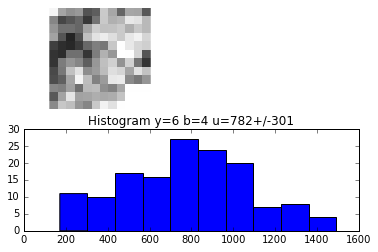

In [416]:
import utils.math_utils as mat_utils
reload(img_utils)
print gtab.bvals[0]
normalize = mat_utils.normalize
img_utils._ish(A, b=4, vmin=0, vmax=1200)
np.any(A<=0)


(array([ 40.,   9.,  12.,  15.,  24.,  24.,  11.,   4.,   2.,   3.]),
 array([ 0.  ,  0.07,  0.14,  0.21,  0.28,  0.35,  0.42,  0.49,  0.56,
         0.63,  0.7 ]),
 <a list of 10 Patch objects>)

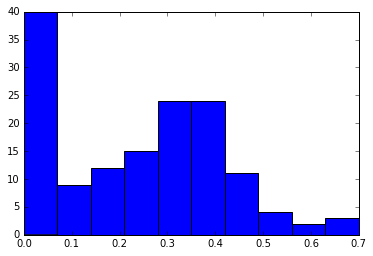

In [384]:
hist(A[:,6,:, 4].flatten(), range=(0,0.7))

In [ ]:
b=4
img_utils._isc(A, i_hr, b=b, vmin=0, vmax=1500, titles=['recons', 'orig'])

#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A[:,6,:,b].min(), A[:,6,:,b].mean(), A[:,6,:,b].max())
print 'orig',(i_hr[:,6,:,b].min(), i_hr[:,6,:,b].mean(), i_hr[:,6,:,b].max())
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'dif_norm_lrs', dif_norm_lrs   
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Ylr_recons_norms', Ylr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'Ylr_norms', Ylr_norms
print 'times',times
print 'optimal_vals', optimal_vals

(14328, 35423375360)

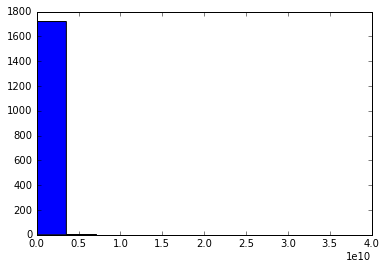

In [376]:
# Lo mismo normalizado
#img_utils._isc(normalize(A), normalize(i_hr), b=b, vmin=0, vmax=1, titles=['N(recons)', 'N(orig)'])
hist(mse.flatten())
mm(mse)

(8047, 11805038)

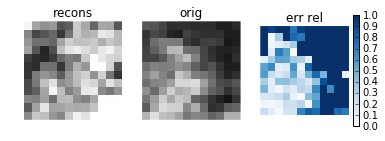

In [377]:
#mse = ((A-i_hr)**2).mean(axis=3)
mse = ((A-i_hr)**2).mean(axis=3)

err = np.abs(A - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

titles=['recons', 'orig', 'err rel']
plt, _, _, im3 = img_utils._isc3(A, i_hr, err_rel,  b=4, vmin=[0, 0], vmax=[1200,1] ,titles=titles)
plt.colorbar(im3,fraction=0.056, pad=0.04)
mm(mse)
#hist(err_rel.flatten(), range=(0,6))

(0, 1024)
Error relativo max,min u std (0, 14) 0 0
max/min i_hr: (16, 3105) 878.869 Eq: (16, 2629) 788.535361093
norm2(C)= 122135.0 norm1= 5021572.70743


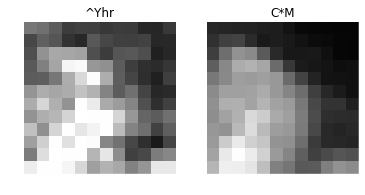

In [410]:
Nx, Ny, Nz, Nb = i_hr.shape
Nb, Nc =  M.shape
Eq_reconst = M.dot(C.reshape((Nx*Ny*Nz, Nc), order='F').T).T#mapl_predict(gtab, C.reshape((Nx*Ny*Nz, Nc), order='F'), M, tau, Nx, Ny, Nz)
Eq_reconst = Eq_reconst.reshape((Nx, Ny, Nz, Nb), order='F')

err = np.abs(Eq_reconst - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst, b=b, vmin=0, vmax=1200, titles=['i_hr', 'cvxpy'])
img_utils._isc(A, Eq_reconst,b=4, vmin=0, vmax=900, titles=['^Yhr', 'C*M'])

#img_utils._is( Eq_reconst,b=4, vmin=0, vmax=3000)
print 'max/min i_hr:',mm(i_hr),i_hr.mean(),'Eq:', mm(Eq_reconst), Eq_reconst.mean()
np.any(Eq_reconst<=0)
print 'norm2(C)=', np.linalg.norm(C), 'norm1=', cvx.norm1(C.flatten()).value

84.6906565657 %rales


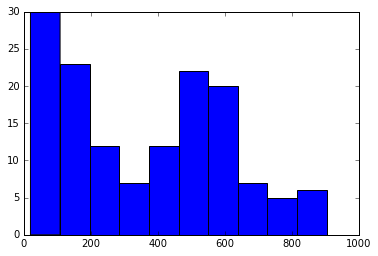

In [409]:
hist(Eq_reconst[:,6,:, 4].flatten())
print np.sum(np.abs(C[:,6,:,:]) <= 0.9)/ float(C[:,6,:,:].size)*100, '%rales'

fidelidad_sum_squares= 178687461.639
dif(fidelidad_sum_squares) 72660379.6677
err_rel(fidelidad_sum_squares) 0.289082966816


True


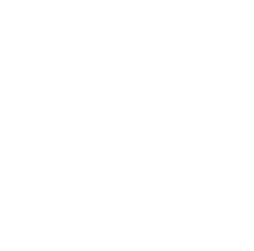

In [304]:
#cvxMaplE.size, 12*12*12
MC = np.asarray(cvxMaplE.value, dtype='float32')#.reshape(i_hr_shape, order='F')

MC = MC.reshape((Nx, Ny, Nz, Nb), order='F')

img_utils._is( MC,b=4, vmin=-10, vmax=0)
print np.any(MC<=-2)